In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance

In [2]:
full_data = pd.read_csv("data/mtsamples.csv")
full_data = full_data.dropna(
    subset=["description", "transcription", "medical_specialty"]
).reset_index(drop=True)

full_data["description"] = full_data["description"].str.lower()
full_data["transcription"] = full_data["transcription"].str.lower()
full_data["medical_specialty"] = full_data["medical_specialty"].str.strip()

In [3]:
general_categories_rows = full_data["medical_specialty"].isin(
    [
        "Surgery",
        "SOAP / Chart / Progress Notes",
        "Office Notes",
        "Consult - History and Phy.",
        "Emergency Room Reports",
        "Discharge Summary",
        "Pain Management",
        "General Medicine",
    ]
)
data = full_data.drop(full_data[general_categories_rows].index)
data = data.reset_index(drop=True)

In [4]:
data["medical_specialty"] = data["medical_specialty"].str.replace(
    "Neurosurgery", "Neurology"
)
data["medical_specialty"] = pd.Categorical(data["medical_specialty"])
data["labels"] = data["medical_specialty"].cat.codes

In [5]:
categories_mapping = dict(enumerate(data["medical_specialty"].cat.categories))
top_categories_num = 5
cause_dist = data["medical_specialty"].value_counts()[0:top_categories_num]
cause_dist_unseen_cat = data["medical_specialty"].value_counts()[top_categories_num:]

test_unseen_categories = data[
    data["medical_specialty"].isin(cause_dist_unseen_cat.keys())
]
test_unseen_categories = test_unseen_categories.reset_index(drop=True)


unseen_categories_groups = test_unseen_categories.groupby(
    test_unseen_categories["medical_specialty"]
)
test_unseen_categories = unseen_categories_groups.filter(lambda x: x.shape[0] > 50)

unseen_categories_mapping = dict(
    enumerate(test_unseen_categories["medical_specialty"].cat.categories)
)

data = data[data["medical_specialty"].isin(cause_dist.keys())]
data = data.reset_index(drop=True)

/var/folders/bq/c80vs6ps41g7kryqnrgx11wm0000gn/T/ipykernel_2361/1820037989.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unseen_categories_groups = test_unseen_categories.groupby(


medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Name: count, dtype: int64
medical_specialty
Cardiovascular / Pulmonary    371
Orthopedic                    355
Neurology                     317
Radiology                     273
Gastroenterology              224
Name: co

(-1.0999951247597746,
 1.0999997678457036,
 -1.0999991955560877,
 1.0999995121443917)

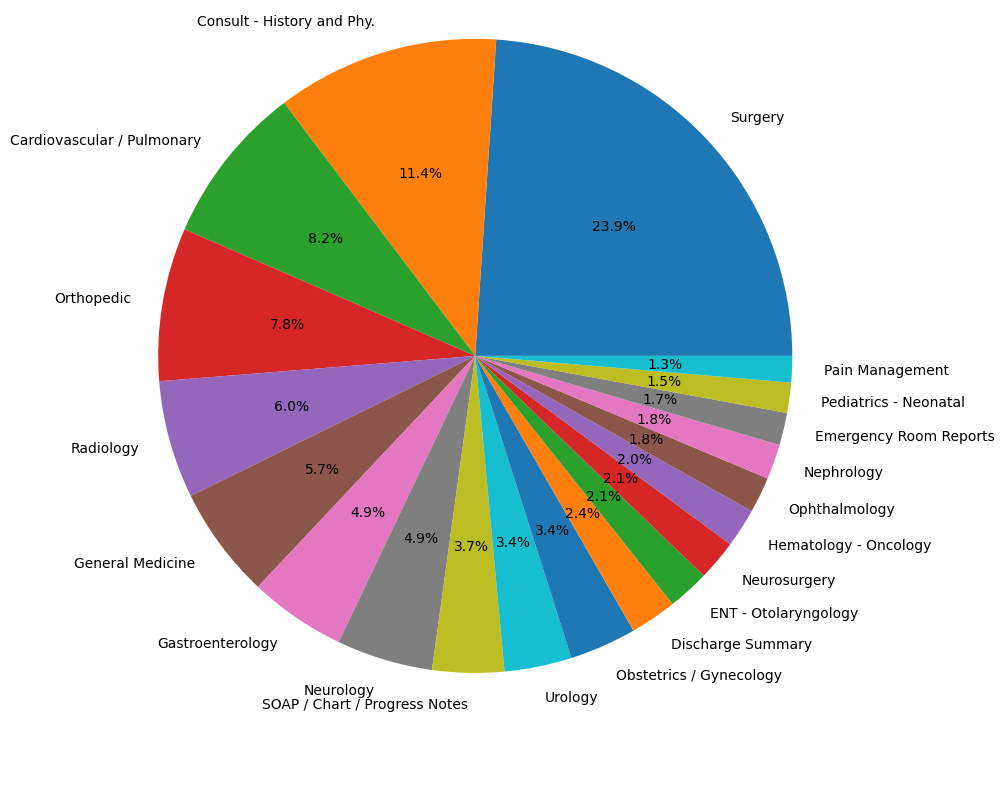

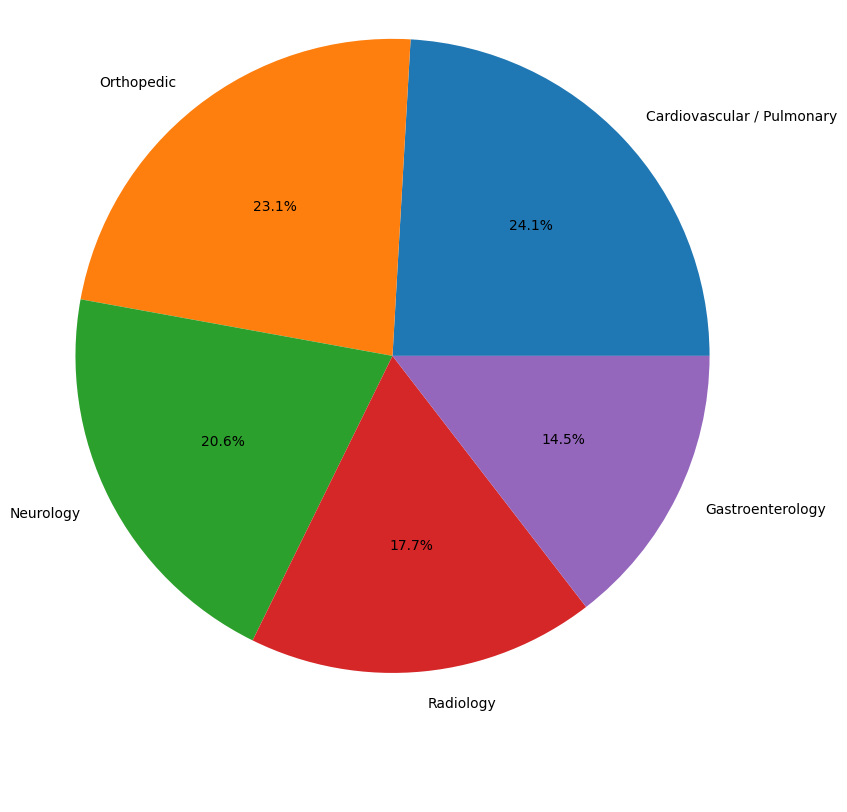

In [6]:
cause_dist = full_data["medical_specialty"].value_counts()[0:20]
print(cause_dist)
plt.figure(figsize=(9, 9))
plt.title(" ", y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis("equal")
# выбранные категории
cause_dist = data["medical_specialty"].value_counts()[0:top_categories_num]
print(cause_dist)
plt.figure(figsize=(9, 9))
plt.title(" ", y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis("equal")

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    data["description"],
    data["labels"],
    random_state=42,
    test_size=0.3,
    stratify=data["labels"],
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=42, test_size=0.5, stratify=temp_labels
)


unseen_train_text, unseen_test_text, unseen_train_labels, unseen_test_labels = (
    train_test_split(
        test_unseen_categories["description"],
        test_unseen_categories["labels"],
        random_state=42,
        test_size=0.2,
        stratify=test_unseen_categories["labels"],
    )
)

In [8]:
MAX_SENTENCE_LENGTH = 70
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

In [9]:
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" 
tokenizer = BertTokenizerFast.from_pretrained(model_name)

texts = [train_text, val_text, test_text, unseen_train_text, unseen_test_text]
tokens_texts = []

for text in texts:
    tokens_texts.append(
        tokenizer.batch_encode_plus(
            text.tolist(),
            max_length=MAX_SENTENCE_LENGTH,
            padding="max_length",
            truncation=True,
        )
    )

(
    train_tokinized,
    val_tokinized,
    test_tokinized,
    unseen_train_tokinized,
    unseen_test_tokinized,
) = tokens_texts

In [10]:
def convert_to_tensors(data, labels):

    seq = torch.tensor(data["input_ids"])
    mask = torch.tensor(data["attention_mask"])
    y = torch.tensor(labels.tolist())

    return seq, mask, y


train_seq, train_mask, train_y = convert_to_tensors(train_tokinized, train_labels)
val_seq, val_mask, val_y = convert_to_tensors(val_tokinized, val_labels)
test_seq, test_mask, test_y = convert_to_tensors(test_tokinized, test_labels)

unseen_train_seq, unseen_train_mask, unseen_train_y = convert_to_tensors(
    unseen_train_tokinized, unseen_train_labels
)
unseen_test_seq, unseen_test_mask, unseen_test_y = convert_to_tensors(
    unseen_test_tokinized, unseen_test_labels
)

In [11]:
class ContrastiveDataset(Dataset):

    def __init__(self, train_seq, train_mask, train_y, positive_prob=0.5):

        super().__init__()
        self.train_seq = train_seq
        self.train_mask = train_mask
        self.train_y = train_y
        self.positive_prob = positive_prob 
        self.hash_table = {}  # format: {"category" : [i1, i2, ...]}

        # construct a hash table, each key is a category
        # and the value is a list of the indexs of the texts which belong to this category
        for i in range(len(self.train_seq)):
            label = self.train_y[i].item()
            if label in self.hash_table:
                self.hash_table[label].append(i)
            else:
                self.hash_table[label] = [i]

    def __getitem__(self, index):
        """
        Sample two texts from the same category with probability self.positive_prob
        :param index: index (int)
        :return:  seq_0 - a sequence of IDs (each ID represent a word in the vocabulary)
                  seq_1 - a sequence which differnt from seq0 (different text)
                  mask_0 - attention mask for seq1
                  mask_1 - attention mask for seq1
                  same_class - 1 if seq0 and seq1 are both from the same category, 0 otherwise
        """
        same_class = random.uniform(0, 1)
        same_class = same_class > self.positive_prob

        seq_0 = self.train_seq[index]
        mask_0 = self.train_mask[index]
        label_0 = self.train_y[index].item()
        class_samples = self.hash_table[label_0]

        if (
            len(class_samples) < 2
        ):  # handle the case where there are only a single text in some category (in this case we can't draw another text from this category...)
            same_class = False

        if same_class:
            while True:
                rnd_idx = random.randint(0, len(class_samples) - 1)
                index_1 = class_samples[rnd_idx]
                if index_1 != index:
                    seq_1 = self.train_seq[index_1]
                    mask_1 = self.train_mask[index_1]
                    label_1 = self.train_y[index_1].item()
                    break
        else:
            while True:
                index_1 = random.randint(0, self.__len__() - 1)
                if index_1 != index:
                    seq_1 = self.train_seq[index_1]
                    mask_1 = self.train_mask[index_1]
                    label_1 = self.train_y[index_1].item()
                    if label_1 != label_0:
                        break

        return seq_0, seq_1, mask_0, mask_1, torch.tensor(same_class, dtype=torch.float)

    def __len__(self):
        return len(self.train_seq)


class SimpleDataset(Dataset):

    def __init__(self, seq, mask, y, positive_prob=0.5):

        super().__init__()
        self.seq = seq
        self.mask = mask
        self.y = y

    def __getitem__(self, index):
        """
        Sample texts by the order of the training set.
        :param index: index (int)
        :return: seq - a sequence of IDs (each ID represent a word in the vocabulary)
                 mask - attention mask for seq
                 y - the category of this text

        """
        return self.seq[index], self.mask[index], torch.tensor(self.y[index].item())

    def __len__(self):
        return len(self.seq)

In [12]:
train_set = ContrastiveDataset(train_seq, train_mask, train_y)
val_set = ContrastiveDataset(val_seq, val_mask, val_y)
test_set = ContrastiveDataset(test_seq, test_mask, test_y)

train_set_simple = SimpleDataset(train_seq, train_mask, train_y)
test_set_simple = SimpleDataset(test_seq, test_mask, test_y)
unseen_train_set_simple = SimpleDataset(
    unseen_train_seq, unseen_train_mask, unseen_train_y
)
unseen_test_set_simple = SimpleDataset(unseen_test_seq, unseen_test_mask, unseen_test_y)

trainLoader = DataLoader(
    train_set, batch_size=32, shuffle=True, drop_last=False, num_workers=0
)
valLoader = DataLoader(
    val_set, batch_size=32, shuffle=True, drop_last=False, num_workers=0
)
testLoader = DataLoader(
    test_set, batch_size=10, shuffle=False, drop_last=False, num_workers=0
)

trainLoader_simple = DataLoader(
    train_set_simple, batch_size=32, shuffle=False, drop_last=False, num_workers=0
)
testLoader_simple = DataLoader(
    test_set_simple, batch_size=64, shuffle=False, drop_last=False, num_workers=0
)
unseen_trainLoader_simple = DataLoader(
    unseen_train_set_simple,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)
unseen_testLoader_simple = DataLoader(
    unseen_test_set_simple, batch_size=64, shuffle=False, drop_last=False, num_workers=0
)

In [13]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # For cls_hs output (First token embedding)

        # self.fc1 = nn.Linear(768,512)
        # self.dropout = nn.Dropout(0.1)
        # self.relu =  nn.ReLU()
        # self.fc2 = nn.Linear(512,128)

        # For hs output (all tokens embeddings)
        # https://chriskhanhtran.github.io/posts/cnn-sentence-classification/
        self.conv1 = nn.Conv1d(
            in_channels=768, out_channels=128, kernel_size=3, stride=1
        )  # kernal_size=3 == three-grams
        self.avg_pooling = nn.AvgPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(
            in_channels=128, out_channels=64, kernel_size=3, stride=1
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.2)

        # Other options:
        # Mean of the token embeddings
        # Max of the token embedding

    def forward(self, seq, mask):

        # Explaination on BERT and its outputs:
        # https://towardsdatascience.com/tips-and-tricks-for-your-bert-based-applications-359c6b697f8e
        # To sum up: BERT is a transformer encoder, meanning it produces representations of the inputs, and hence we can use it for several tasks.

        # BERT returns a dictionary of vectors where the first is called 'sequence output' (or 'hidden state'=hs) and the other is 'pooled output' (or 'cls_hs').
        # ** 'sequence_output' is of shape [batch_size, max_seq_length, 768] with representations for each input token (including start symbol and end symbol)
        # ** 'pooled_output' is of shape [batch_size, 768] with representations for the entire input sequences. It created by taking only the first token embedded vector (start symbol)
        #     (and pass it throgh more layers (?))

        # The idea of "pooled_output":
        # Since, the embeddings from the BERT model at the output layer are known to be contextual embeddings, the output of the 1st token, i.e, [CLS] token
        # would have captured sufficient context. Hence, the authors of BERT paper found it sufficient to use only the output from the 1st token for few tasks
        # such as classification. They call this output from the single token (i.e, 1st token) as pooled_output.

        # Get embeddings from bert.
        # Output shape: hs = (b, max_len_seq, embed_dim)
        #               cls = (b, embed_dim)
        # where:  b: batch_size
        #         max_len_seq=number of tokens in the longest text (we defined it erilier)
        hs, cls_hs = self.bert(seq, attention_mask=mask, return_dict=False)

        # x = self.fc1(cls_hs)
        # x = self.dropout(x)
        # x = self.relu(x)
        # x = self.fc2(x)

        x = hs.permute(
            0, 2, 1
        ).contiguous()  # Permute `hs` to match input shape requirement of `nn.Conv1d`
        # The contiguous() ensures the memory of the tensor is stored contiguously
        # which helps avoid potential issues during processing.
        # Output shape: (b, 768, 70) = (b, embed_dim, max_len_seq).

        x = F.relu(
            self.conv1(x)
        )  # Output shape: (b, 128, *)  * depends on kernel size and padding
        x = self.avg_pooling(x)  # Output shape: (b, 128, *)
        x = F.relu(self.conv2(x))  # Output shape: (b, 128, *)
        x = F.max_pool1d(
            x, kernel_size=x.shape[2]
        )  # Output shape: (b, 128, 1) # trick: we use kernel of size x.shape[2] to reduce from * to 1
        x = self.flatten(x)  # Output shape: (b, 128)
        x = self.fc(x)  # Output shape: (b, 128)
        x = self.dropout(x)

        return x


class SiameseNeuralNetwork(nn.Module):

    def __init__(self, bert_arch):
        super().__init__()  # TODO super?

        self.bert_arch = bert_arch
        self.distance_layer = nn.Sequential(
            nn.Linear(128, 1), nn.Sigmoid()
        )  # if we would use BCEWithLogitsLoss as loss function, we should delte the sigmoid since we dont need it after the linear layer a sigmoid layer

    def forward(self, seq1, seq2, mask1, mask2):
        feature_vec1 = self.bert_arch(
            seq1, mask1
        )  # feature_vec1 shape:  [batch_size, embedding_size]
        feature_vec2 = self.bert_arch(seq2, mask2)
        difference = torch.abs(feature_vec1 - feature_vec2)
        out = self.distance_layer(difference)
        return out  # feature_vec1, feature_vec2#out

In [14]:
def train_siamese_network(model, optimizer, dataloaders, num_epochs, criterion, es_limit):
    epochloop = tqdm(range(num_epochs), position=0, desc="Training", leave=True)
    
    es_trigger = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "matching_similarity": [],
        "non_matching_similarity": [],
        "val_matching_similarity": [],
        "val_non_matching_similarity": [],
        "epochs": num_epochs,
    }
    val_loss_min = torch.inf
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True, min_lr=0.0001)  ########################################################
    # cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1, cycle_momentum=False) ########################################################

    for epoch in epochloop:  # loop over the train dataset multiple times

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for i, (seq1, seq2, mask1, mask2, label) in enumerate(dataloaders[phase]):
                if phase == "train":
                    epochloop.set_postfix_str(f"Train batch {i+1}/{len(dataloaders[phase])}")

                seq1, seq2, mask1, mask2, label = (
                    seq1.to(DEVICE),
                    seq2.to(DEVICE),
                    mask1.to(DEVICE),
                    mask2.to(DEVICE),
                    label.to(DEVICE),
                )

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history  only in train
                with torch.set_grad_enabled(phase == "train"):
                    
                    # forward
                    output = model.forward(seq1, seq2, mask1, mask2)
                    loss = criterion(
                        output, label.view(output.size())
                    )  # criterion(output.squeeze(0), label.view(1))    label.view((trainLoader.batch_size,1))

                    # backward + optimize only if in training phase
                    if phase == "train":  #  
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(
                            model.parameters(), 1.0
                        )  # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
                        optimizer.step()
                        # cyclic_scheduler.step() ########################################################

                        # save similarity scores for training data
                        output = output.cpu().detach().numpy()
                        label = label.cpu().numpy()
                        history["non_matching_similarity"].append(
                            (sum(output[label == 0]) / sum(label == 0)).item()
                        )
                        history["matching_similarity"].append(
                            (sum(output[label == 1]) / sum(label == 1)).item()
                        )

                    if phase == "val":
                        with torch.no_grad():
                            history["val_non_matching_similarity"].append(
                                (sum(output[label == 0]) / sum(label == 0)).item()
                            )
                            history["val_matching_similarity"].append(
                                (sum(output[label == 1]) / sum(label == 1)).item()
                            )

                running_loss += loss.item() * seq1.size(
                    0
                )  # we multiply by the batch size (note that the batch size in the last batch may not be the batch size we did since the batch size dont necceraly divide the train size)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == "train":
                history["train_loss"].append(epoch_loss)
            else:
                history["val_loss"].append(epoch_loss)
                if epoch_loss <= val_loss_min:
                    val_loss_min = epoch_loss
                    es_trigger = 0
                else:
                    epochloop.write(
                        f"[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {epoch_loss:.3f})"
                    )
                    es_trigger += 1
                # scheduler.step(epoch_loss) ########################################################
        if es_trigger >= es_limit:
            epochloop.write(f"Early stopped at Epoch-{epoch+1}")
            history["epochs"] = epoch + 1
            break

    return history

In [15]:
def plot_losses(history):

    fig = go.Figure()

    line_color = [px.colors.qualitative.Light24[5], px.colors.qualitative.Light24[4]]

    fig.add_trace(
        go.Scatter(
            x=list(range(1, history["epochs"] + 1)),
            y=history["train_loss"],
            mode="lines",
            line=dict(color=line_color[0], width=1),
            name="train loss",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=list(range(1, history["epochs"] + 1)),
            y=history["val_loss"],
            mode="lines",
            line=dict(color=line_color[1], width=1),
            name="valdiation loss",
        )
    )  # opacity=0.8

    fig.update_yaxes(range=[0, 1])
    fig.update_traces(textposition="top center")
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text="SNN Loss",
        title_x=0.5,
        xaxis_title="Epoch",
        yaxis_title="",
        xaxis=dict(tickmode="linear", tick0=1, dtick=1),
        legend=dict(yanchor="top", xanchor="right", x=1.35, y=1),
        template="plotly_dark",
    )
    fig.show()

In [16]:
def plot_similarity_scores(history):

    train_num_batchs = len(history["non_matching_similarity"])

    fig = go.Figure()

    line_color = [px.colors.qualitative.Light24[22], px.colors.qualitative.Light24[19]]

    fig.add_trace(
        go.Scatter(
            x=list(range(1, train_num_batchs + 1)),
            y=history["non_matching_similarity"],
            mode="lines",
            line=dict(color=line_color[0], width=1),
            name="unmatching categories",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=list(range(1, train_num_batchs + 1)),
            y=history["matching_similarity"],
            mode="lines",
            line=dict(color=line_color[1], width=1),
            name="matching categories",
        )
    )  # opacity=0.8

    fig.update_yaxes(range=[0, 1])
    fig.update_traces(textposition="top center")
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text="Similarity Scores",
        title_x=0.5,
        xaxis_title="Batch",
        yaxis_title="",
        legend=dict(yanchor="top", xanchor="right", x=1.35, y=1),
        template="plotly_dark",
    )
    fig.show()

In [17]:
def train_model():
    bert = AutoModel.from_pretrained(model_name)

    for param in bert.parameters():
        param.requires_grad = False

    bert_arch = BERT_Arch(bert)

    criterions = (
        torch.nn.BCELoss(),
        torch.nn.BCEWithLogitsLoss(reduction="mean"),
        torch.nn.BCELoss(reduction="mean"),
    )
    optimizers = (
        {"name": torch.optim.Adam, "params": {"lr": 0.00001}},
        {"name": torch.optim.SGD, "params": {"lr": 0.001, "momentum": 0.9}},
        {"name": torch.optim.AdamW, "params": {"lr": 0.005}},
    )
    num_epochs = 30
    for criterion in criterions:
        for optimizer in optimizers:
            SNN_model = SiameseNeuralNetwork(bert_arch).to(DEVICE)
            optimizer = optimizer["name"](SNN_model.parameters(), **optimizer["params"])
            history = train_siamese_network(
                SNN_model,
                optimizer,
                dataloaders={"train": trainLoader, "val": valLoader},
                num_epochs=num_epochs,
                criterion=criterion,
                es_limit=10,
            )
            plot_losses(history)
            plot_similarity_scores(history)

    return SNN_model

In [18]:
model_ = train_model()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:  10%|█         | 3/30 [00:48<07:00, 15.56s/it, Train batch 1/34] 

[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training:  10%|█         | 3/30 [00:59<08:57, 19.90s/it, Train batch 32/34]


KeyboardInterrupt: 

In [ ]:
def construct_train_matrix(SNN_model, trainLoader_simple):
    """
    Embed the training data using the trained SNN model.
    """

    # Get intermidate layer output.
    # Source: https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()

        return hook

    # SNN_model.bert_arch.fc1.register_forward_hook(get_activation('fc1'))
    SNN_model.bert_arch.fc.register_forward_hook(get_activation("fc"))

    train_matrix = []
    epochloop = tqdm(range(len(trainLoader_simple)), position=0, desc="Training", leave=True)
    with torch.no_grad():
        for (seq1, mask1, label1), _ in zip(trainLoader_simple, epochloop):
            seq1, mask1, label1 = (
                seq1.to(DEVICE),
                mask1.to(DEVICE),
                label1.to(DEVICE),
            )

            SNN_model.eval()
            _ = SNN_model(seq1, seq1, mask1, mask1)
            train_matrix.append(
                activation["fc"].cpu().numpy()
            )  # activation['fc1'] return a tensor in cuda with size (batch_size, embedding_dim), so we move it to cpu, than to numpy array.

    return np.vstack(
        train_matrix
    )  # we combine all the batches, so now we return matrix of size (num_samples_train, embedding_dim)


def extract_prototypes(k, trainLoader_simple, train_labels, train_matrix):
    """
    Compute kc (= k/num_classes_train) prototypes for each class in the trainset.
    (if k % num_classes_train != 0 then take the highest k0 <= k which is divisable by num_classes_train)

    :param k:
    :param train_matrix: size (num_samples_train, embedding_dim)
    :return:
    """
    train_labels = list(train_labels)
    train_dataset = trainLoader_simple.dataset  # contains triples of (seq, mask, label)

    # construct a hash table, each key is a class of diagnosis
    # and the value is a list of the indexs of the sentences which belong to this class
    hash_table = {}  # format: {"diagnosis" : [i1, i2, ...]}
    for i in range(len(train_labels)):
        lbl = train_labels[i]
        if lbl in hash_table:
            hash_table[lbl].append(i)
        else:
            hash_table[lbl] = [i]

    # Create prototypess
    prototypes_list = {diagnosis: [] for diagnosis in hash_table.keys()}
    num_classes_train = len(hash_table)
    assert (
        k >= num_classes_train
    ), "k should be greater than the numbrer of uniqe labels in the train set'"
    kc = int(k / num_classes_train)
    print("kc:", kc)

    for diagnosis in hash_table.keys():

        print("diagnosis:", diagnosis)

        if (
            len(hash_table[diagnosis]) <= 1
        ):  # if there is only a single sentence in some diagnosis sentences list - take it as the prototype of this class
            prototypes_list += list(train_matrix[hash_table[diagnosis]])

        else:
            # fit on all sentences which belongs to the same class (diagnosis)
            kmeans = KMeans(n_clusters=kc, init="k-means++").fit(
                train_matrix[hash_table[diagnosis]]
            )
            # extract for each centroid the closest real sample, and add it as a prototype
            for centroid in kmeans.cluster_centers_:
                # print(train_matrix[hash_table[diagnosis]].shape)
                best_match_index = None
                best_match_dist = float("inf")
                for sentence_index in hash_table[diagnosis]:
                    # print(sentence_index)
                    embedded_sent = train_matrix[sentence_index]
                    dist = distance.euclidean(centroid, embedded_sent)
                    # print("dist:", best_match_dist)
                    if dist < best_match_dist:
                        best_match_dist = dist
                        best_match_index = sentence_index
                # print(best_match_index)
                prototypes_list[diagnosis].append(train_dataset[best_match_index])

    return prototypes_list

In [ ]:
from sklearn.decomposition import PCA


def show_space(X_pca, colors=None, elev=50, azim=30):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    X = X_pca[:, 0]
    Y = X_pca[:, 1]
    Z = X_pca[:, 2]
    if(X_pca.shape[1] > 3):
        S = X_pca[:, 3]
        mean_value = np.mean(S)
        diff = 5 - mean_value
        S += diff
        S *= 5
    else:
        S = 25
    
    scatter = ax.scatter(X, Y, Z, c=colors, cmap='viridis', s=S)
    
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1, aspect=30)
    cbar.set_label('Class')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.view_init(elev=elev, azim=azim)
    
    plt.show()

In [ ]:
train_matrix = construct_train_matrix(model_, trainLoader_simple)

Training:  97%|█████████▋| 33/34 [00:10<00:00,  3.19it/s]


In [ ]:
pca_alg = PCA(n_components=3)
X_pca = pca_alg.fit_transform(train_matrix) 

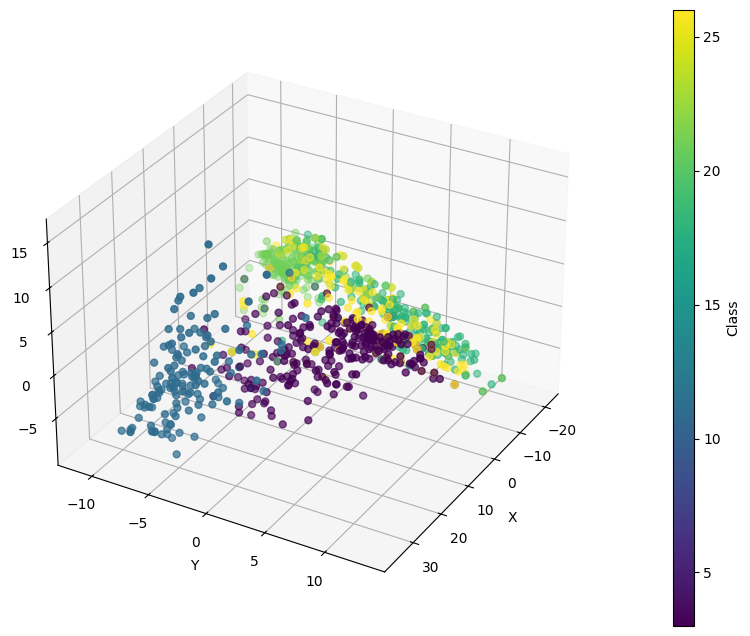

In [ ]:
show_space(X_pca, colors=pd.DataFrame(train_labels), elev=30, azim=30)

In [ ]:
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.783653   0.11373234 0.03025184]
Comulative explained variance: [0.783653   0.89738536 0.9276372 ]


In [ ]:
def project_to_dissimilarity_space(dataLoader, model, prototypes_list):
    """

    Parameters
    ----------
    dataLoader :
    SNN_model :


    Returns
    -------
    projected_data : numpy array of shape (num_samples_data, projection_dim)
    """
    epochloop = tqdm(range(len(dataLoader)), position=0, desc="Training", leave=True)
    projected_data = []
    with torch.no_grad():
        for (seq1, mask1, label1), _ in zip(dataLoader, epochloop):

            projected_sentence = []
            seq1, mask1, label1 = seq1.to(DEVICE), mask1.to(DEVICE), label1.to(DEVICE)

            for diagnosis in prototypes_list:
                # print("diagnosis:", diagnosis)
                for centroid in prototypes_list[
                    diagnosis
                ]:  # centroid contains a triple of (seq, mask, label)
                    seq2, mask2 = centroid[0].repeat(seq1.shape[0], 1), centroid[
                        1
                    ].repeat(
                        mask1.shape[0], 1
                    )  # we stack to seq2 and mask2 replications of them such that they will fit the batch size of seq1 and mask2

                    seq2, mask2 = seq2.to(DEVICE), mask2.to(DEVICE)

                    model.eval()
                    distance = model(seq1, seq2, mask1, mask2)
                    projected_sentence.append(distance.squeeze().cpu().numpy())

            projected_data.append(np.array(projected_sentence).T)
            # break # TODO delete

    projected_data = np.vstack(projected_data)
    return projected_data

In [ ]:
prototypes_list = extract_prototypes(100, trainLoader_simple, train_labels, train_matrix)

kc: 20
diagnosis: 26
diagnosis: 21
diagnosis: 3
diagnosis: 11
diagnosis: 18


In [ ]:
projected_train = project_to_dissimilarity_space(trainLoader_simple, model_, prototypes_list)

Training:  97%|█████████▋| 33/34 [17:08<00:31, 31.16s/it]


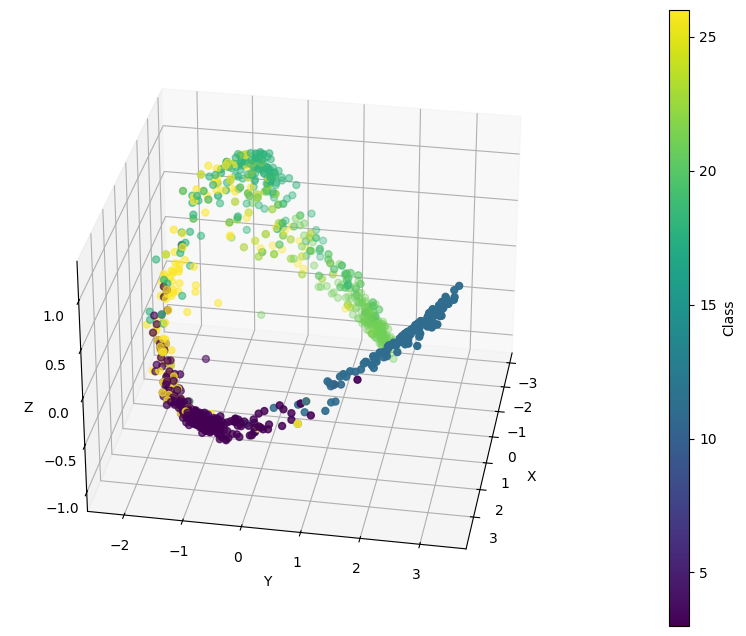

Explained variance per component: [0.6807609  0.24544197 0.04905913]
Comulative explained variance: [0.6807609  0.9262029  0.97526205]


In [ ]:
X_pca = pca_alg.fit_transform(projected_train) 
show_space(X_pca, colors=pd.DataFrame(train_labels), elev=30, azim=10)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

In [ ]:
from collections import Counter
from sklearn.svm import SVC


def ensemble_of_classifiers(projected_train, train_y):
    """
    For each category a classifier is trained to discriminate between this category and all the other categories put together.

    Parameters
    ----------
    projected_train : shape (num_samples_train, projection_dim)
    train_y : shape (num_samples_train)


    Returns
    -------
    classifiers_list : a list of trained classifiers. The it'h classifier desined to predict the i'th category.
    diagnosis_list : list of the categories order as the classifiers.
    """

    classifiers_list = []

    diagnosis_list = np.sort(
        list(Counter(list(train_y)).keys())
    )  # orderd by increasing order: (0,1,2,..)

    for diagnosis in diagnosis_list:
        print(diagnosis)

        y = np.zeros(len(train_y))
        is_diagnosis = train_y == diagnosis
        y[is_diagnosis] = 1
        y = y.astype("int")
        if y.sum() == 0:  # TODO delete
            continue
        classifier = SVC(gamma="auto", probability=True)
        classifier.fit(projected_train, y)

        classifiers_list.append(classifier)

    return classifiers_list, diagnosis_list

In [ ]:
classifiers, categories_order = ensemble_of_classifiers(projected_train,  train_labels)

3
11
18
21
26


In [ ]:
projected_test = project_to_dissimilarity_space(testLoader_simple, model_, prototypes_list)

Training:  75%|███████▌  | 3/4 [03:32<01:10, 70.83s/it]


In [ ]:
X_pca = pca_alg.fit_transform(projected_test) 

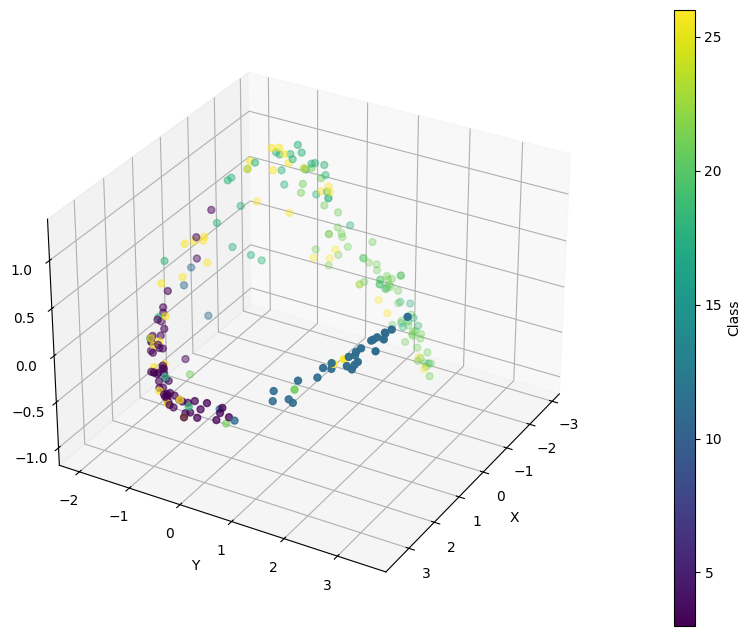

Explained variance per component: [0.68479127 0.2441674  0.04363356]
Comulative explained variance: [0.68479127 0.92895865 0.97259223]


In [ ]:
show_space(X_pca, colors=pd.DataFrame(test_labels), elev=30, azim=30)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def predict(projected_test, classifiers_list, categories_order):

    pred_y = []

    for classifier in classifiers_list:
        pred_y.append(
            classifier.predict_proba(projected_test)[:, 1]
        )  # predict_proba returns probabiltiy for class==0 and for class==1, so we take only the probabilities of class==1

    pred_y = np.vstack(pred_y)  # (num_classifiers, num_samples_test)
    highest_predictions = categories_order[np.argmax(pred_y, axis=0)]
    print(pred_y)
    print(highest_predictions)
    return highest_predictions


def plot_confusion_matrix(mat, fig_size, labels):

    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(mat, annot=True, cmap="Blues", ax=ax, fmt="g")
    # annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment="right")
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    plt.show()

[[8.89793988e-01 7.38631106e-01 8.98653960e-01 ... 4.32710868e-05
  3.10973401e-04 9.01500381e-01]
 [1.63702540e-02 3.11070828e-03 3.93323474e-03 ... 1.51399073e-02
  1.06845168e-02 2.40064909e-02]
 [1.37300812e-02 1.77819745e-02 1.62503602e-02 ... 3.36493345e-01
  8.73290232e-01 9.29130379e-03]
 [1.27392367e-02 7.48749952e-03 8.31727081e-03 ... 3.62500633e-01
  1.26763592e-02 9.50626018e-03]
 [5.37617510e-02 3.30789878e-01 7.39144076e-02 ... 7.67841801e-02
  1.57984754e-01 6.01255064e-02]]
[ 3  3  3 18  3 21 18 11 21 18 21 26 18 18 26  3 21 18 18  3  3 11  3 18
 18  3 26 26  3 21 21 21 26 21 26  3  3 21 11 11 21 26 21 18 21  3 26 26
 18 26  3 11 21  3 11  3 21 21 26  3 18 18 18 21  3 26  3 18 11  3 26 26
 21 18 11 21 26  3 18  3 18  3 21 11 21  3  3  3 18 21  3 26 11 11 21 21
 18 26 21 18 11  3 21 18 26 18  3  3 21 21 11 26 21 26 21 26 18  3 21 11
 21 18 21 21 11  3 11  3  3 26  3 11 11 18 21 21  3  3 11 21  3 18 11  3
 18 11 26 18 21 26 18 21 11 21  3  3  3 21  3 18 21  3  3 21 18 26

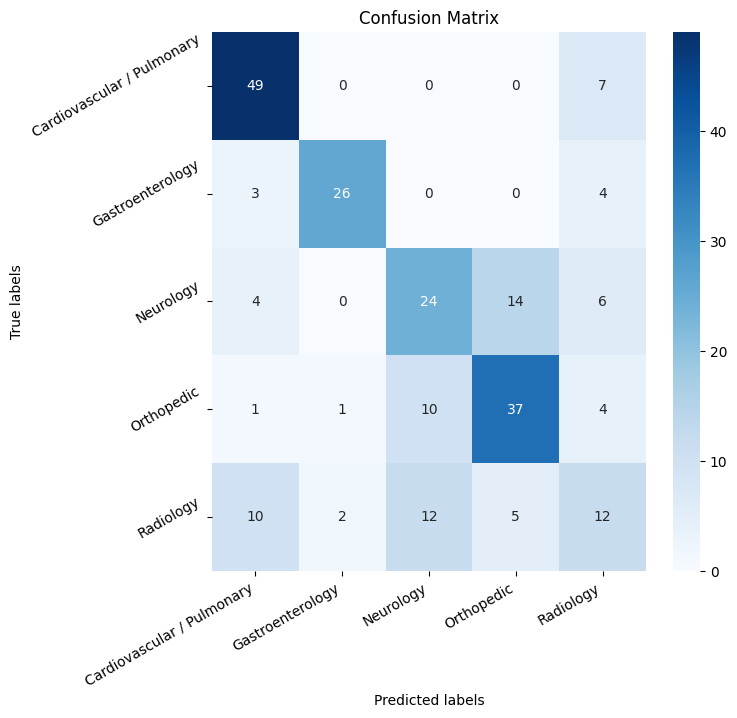

In [ ]:
preds = predict(projected_test, classifiers, categories_order)
c_matrix = confusion_matrix(test_labels, preds)
plot_confusion_matrix(
    c_matrix, fig_size=7, labels=[categories_mapping[c] for c in categories_order]
)

In [ ]:
categories_labels = [categories_mapping[c] for c in categories_order]
print(classification_report(test_labels, preds, target_names=categories_labels))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.73      0.88      0.80        56
          Gastroenterology       0.90      0.79      0.84        33
                 Neurology       0.52      0.50      0.51        48
                Orthopedic       0.66      0.70      0.68        53
                 Radiology       0.36      0.29      0.32        41

                  accuracy                           0.64       231
                 macro avg       0.63      0.63      0.63       231
              weighted avg       0.63      0.64      0.63       231



In [ ]:
unseen_train_matrix = construct_train_matrix(model_, unseen_trainLoader_simple)
unseen_prototypes_list = extract_prototypes(100, unseen_trainLoader_simple, unseen_train_labels, unseen_train_matrix)
unseen_projected_train = project_to_dissimilarity_space(unseen_trainLoader_simple, model_, unseen_prototypes_list)
unseen_classifiers, unseen_categories_order = ensemble_of_classifiers(unseen_projected_train,  unseen_train_labels)

Training:  90%|█████████ | 9/10 [00:05<00:00,  1.56it/s]


kc: 12
diagnosis: 30
diagnosis: 19
diagnosis: 17
diagnosis: 9
diagnosis: 12
diagnosis: 25
diagnosis: 22
diagnosis: 20


Training:  90%|█████████ | 9/10 [09:11<01:01, 61.23s/it]


9
12
17
19
20
22
25
30


In [ ]:
unseen_projected_test = project_to_dissimilarity_space(unseen_testLoader_simple, model_, unseen_prototypes_list)
unseen_preds = predict(unseen_projected_test, unseen_classifiers, unseen_categories_order)

Training:  67%|██████▋   | 2/3 [02:19<01:09, 69.56s/it]

[[0.10387584 0.08936469 0.0620864  ... 0.05404357 0.17875796 0.07116284]
 [0.10179912 0.11277206 0.12256421 ... 0.12438049 0.12172528 0.11992455]
 [0.09948174 0.09925253 0.09956242 ... 0.09467829 0.02973773 0.10523748]
 ...
 [0.08994274 0.0906248  0.09053296 ... 0.09016174 0.09035018 0.09083011]
 [0.08014544 0.02623435 0.00534198 ... 0.01541377 0.02095807 0.02409003]
 [0.18183659 0.17972611 0.17083516 ... 0.1695392  0.12063971 0.17546752]]
[19 19 19 30 30 30 30 19 30 19 19 30 19 19 19 19 19 19  9 30 30 19 30 20
 19 30 19 19 30 30 30 25 30 30 30 20 19 19 19 19 19 19 30 30 30 20 19 19
 30 19 19 19 19 19 30 19 19 30 20 19 19 19 19 30 30 19 19 19 30 19 19 19
 20 30 19 19 30 19 17 30 30 19 30 19 19 19 19 19 19 30 30  9 30 19 19 30
  9 19 19 19 19 19 30 19 30 30 30 19 30 20 19 19 30 20 19 19 19 19 30 30
 30 19 30 19 30 19 19 19 19 30 30 30 20 19 19 19 19 25 19 20 20 19 19 30
 19 30 19 30 30 19 30 19 30 19 19  9 19]


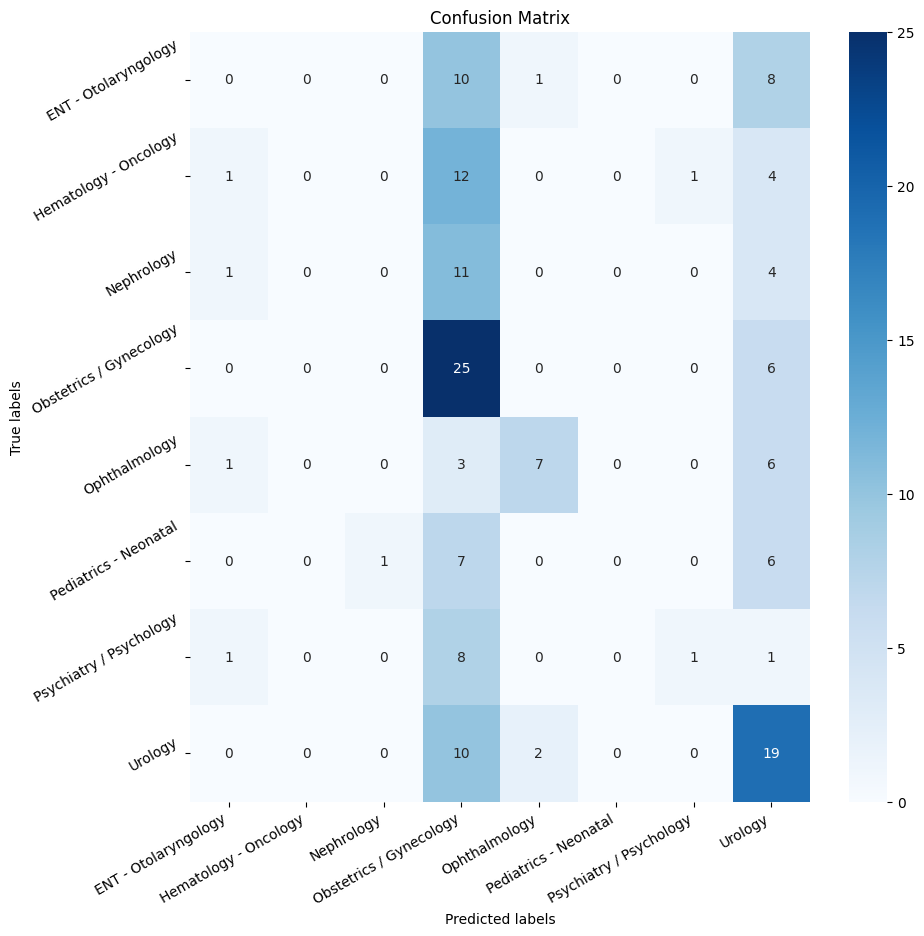

In [ ]:
unseen_c_matrix = confusion_matrix(unseen_test_labels, unseen_preds)
plot_confusion_matrix(unseen_c_matrix, fig_size=10, labels=[unseen_categories_mapping[c] for c in unseen_categories_order])

In [ ]:
unseen_categories_labels = [unseen_categories_mapping[c] for c in unseen_categories_order]
print(classification_report(unseen_test_labels, unseen_preds, target_names=unseen_categories_labels))

                         precision    recall  f1-score   support

   ENT - Otolaryngology       0.00      0.00      0.00        19
  Hematology - Oncology       0.00      0.00      0.00        18
             Nephrology       0.00      0.00      0.00        16
Obstetrics / Gynecology       0.29      0.81      0.43        31
          Ophthalmology       0.70      0.41      0.52        17
  Pediatrics - Neonatal       0.00      0.00      0.00        14
Psychiatry / Psychology       0.50      0.09      0.15        11
                Urology       0.35      0.61      0.45        31

               accuracy                           0.33       157
              macro avg       0.23      0.24      0.19       157
           weighted avg       0.24      0.33      0.24       157



/Users/linearlys/Documents/Projects/ML_NN/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/linearlys/Documents/Projects/ML_NN/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/linearlys/Documents/Projects/ML_NN/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

